In [1]:
from IPython.core.display import display, HTML
display(HTML("""<style> .container {width:96% !important;}</style>"""))

from IPython.display import IFrame

In [2]:
import pandas as pd
import numpy as np
# from plotly.offline import init_notebook_mode, iplot
# import cufflinks as cf
# init_notebook_mode()
# cf.go_offline()
from __future__ import division

In [3]:
import xgboost as xgb

/Users/ehda-calvin/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
!ls additional_data
path = 'additional_data/'

nat03_04.csv
nat05_06.csv
nat07_08.csv
t0001-10.1080%2F10691898.2018.1434342.csv
t0002-10.1080%2F10691898.2018.1434342.csv
t0003-10.1080%2F10691898.2018.1434342.csv
t0004-10.1080%2F10691898.2018.1434342.csv
t0005-10.1080%2F10691898.2018.1434342.csv
t0006-10.1080%2F10691898.2018.1434342.csv
t0007-10.1080%2F10691898.2018.1434342.csv
t0008-10.1080%2F10691898.2018.1434342.csv
t0009-10.1080%2F10691898.2018.1434342.csv
t0010-10.1080%2F10691898.2018.1434342.csv
t0011-10.1080%2F10691898.2018.1434342.csv
t0012-10.1080%2F10691898.2018.1434342.csv
t0013-10.1080%2F10691898.2018.1434342.csv


## Preprocessing

In [5]:
def default(x):
    if x == 'CHGOFF':
        return 1
    else:
        return 0

def to_float(x):
    x = x.replace('$', '')
    x = x.replace(',', '')
    x = float(x)
    return x

def SBA_ratio(SBA_Appv, GrAppv):
    if type(SBA_Appv) != float:
        SBA_Appv = to_float(SBA_Appv)
    if type(GrAppv) != float:
        GrAppv = to_float(GrAppv)
    return SBA_Appv/GrAppv

def franchise(x): 
    # FranchiseCode:    Franchise Code 00000 or 00001 = No Franchise
    if (x == 1) or (x == 0):
        return 0
    else:
        return 1
    
def extract_train_features(features, drop, categorical):
    print('-----> Extract train features <------')
    print 'dropping unwanted columns'
    features = features.drop(drop, axis=1)

    print 'transforming categorical variables'
    dict_categorical = {}
    for col in categorical:
        cat = pd.Categorical(features[col])
        new_col = col[:-1]+'INT'
        if col[-2] == '_':
            new_col = col[:-1]+'INT'
        else:
            new_col = col+'_INT'
        features.loc[:, new_col] = cat.codes
        dict_categorical[col] = dict([(k, v) for v, k in enumerate(cat.categories)])
    features = features.drop(categorical, axis=1)
    print 'done'
    return dict_categorical, features

def extract_test_features(test, drop, categorical, dict_categorical):
    print('-----> Extract test features <------')
    print 'dropping unwanted columns'
    test=test.drop(drop, axis=1)
    print 'transforming categorical variabless'
    for col in categorical:
        new_col = col[:-1]+'INT'
        if col[-2] == '_':
            new_col = col[:-1]+'INT'
        else:
            new_col = col+'_INT'
        test[new_col] = test[col].map(dict_categorical[col])
        test[new_col].fillna(-1, inplace=True)
    test=test.drop(categorical, axis=1)
    print 'done'
    return test

In [7]:
nat34 = pd.read_csv(path + 'nat03_04.csv')
nat34['default'] = nat34.MIS_Status.apply(default)

## Train, Test split

In [8]:
from sklearn import model_selection
train, test = model_selection.train_test_split(nat34, 
                                               test_size = 0.25, 
                                               random_state = 1868,
                                               stratify = nat34.default 
                                               )

print train.shape, test.shape
print train.default.sum()/train.shape[0], test.default.sum()/test.shape[0]


(94862, 28) (31621, 28)
0.163901246021 0.16391005977


In [9]:
# Preprocessing
train['Franchise'] = train['FranchiseCode'].apply(franchise)
train['SBA_ratio'] = train.apply(lambda x: SBA_ratio(x['SBA_Appv'], x['GrAppv']), axis = 1)

/Users/ehda-calvin/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ehda-calvin/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
train.head().T

,19954,123188,6178,119599,73142
LoanNr_ChkDgt,6025814006,7775474004,5757834002,7694714002,6957474000
Name,CARROLL STREET AUTO SALES LLC,LIL EINSTEINS LEARNING ACADEMY,"GET A MOVE ON, INC. A KANSAS C",U S SAFETY & SUPPLY COMPANY LL,EDS TOOL AND DIE INC
City,MANCHESTER,BEAR,WICHITA,EL MONTE,CANFIELD
State,NH,DE,KS,CA,OH
Zip,3102,19701,67214,91731,44406
Bank,"OCEAN BANK, A DIVISION OF",WILMINGTON SAVINGS FUND SOCIET,BANK OF AMERICA NATL ASSOC,EAST WEST BANK,JPMORGAN CHASE BANK NATL ASSOC
BankState,NH,DE,NC,CA,IL
NAICS,441120,624410,812990,423990,333511
ApprovalDate,15-Jan-03,8-Sep-04,4-Oct-02,13-Aug-04,24-Nov-03
ApprovalFY,2003,2004,2003,2004,2004


In [11]:
# Preprocessing train set
features = train
target = train.default

drop = ['LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'ApprovalFY', 'ChgOffDate', 'DisbursementDate',
        'DisbursementGross', 'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 
        'default', 'FranchiseCode', 'Term']

categorical = ['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'RevLineCr', 'LowDoc'
              ]

dict_categorical, features = extract_train_features(features,
                                                    drop,
                                                    categorical)

print features.shape
print target.sum()

-----> Extract train features <------
dropping unwanted columns
transforming categorical variables
done
(94862, 15)
15548


In [12]:
features.head()

,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,Franchise,SBA_ratio,City_INT,State_INT,Zip_INT,Bank_INT,BankState_INT,NAICS_INT,RevLineCr_INT,LowDoc_INT
19954,4,1.0,0,4,1,0,0.50,5149,30,607,1710,31,703,1,1
123188,14,2.0,4,18,2,0,0.75,552,8,3704,2514,8,1086,0,1
6178,3,1.0,0,3,1,0,0.50,9627,16,10938,192,28,1163,4,1
119599,12,1.0,0,12,1,0,0.75,2597,4,14364,775,4,667,0,1
73142,10,1.0,0,10,2,0,0.50,1250,35,7300,1374,15,424,4,1


In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, 
                                                                    target, 
                                                                    test_size = 0.25, 
                                                                    random_state=3776,
                                                                    stratify=target 
                                                                   )


dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dtest = xgb.DMatrix(X_test.values, y_test.values)
num_rounds = 1100
# num_rounds = 2000

params = {'silent':0, 
          'eta':0.01, 
          'max_depth':10, 
          'subsample': 0.7, 
          'colsample_bytree': 0.7,
          'min_child_weight':1, 
          'objective':'binary:logistic', 
          'eval_metric':'auc', 
          'seed':2017, 
          'gamma':0.1,
          'nthread':-1}

watchlist = [(dtrain, 'train'),(dtest,'validation')]
bst=xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds = 50, verbose_eval = False)
num_rounds = bst.best_iteration
print num_rounds

737


In [14]:
# Use all the train data to train the model

X_train_matrix = features.values

#SKLEARN
clf_xgb = xgb.XGBClassifier(silent = 0,
                            learning_rate = params['eta'],  
                            max_depth = params['max_depth'], 
                            subsample = params['subsample'], 
                            colsample_bytree = params['colsample_bytree'],
                            min_child_weight = params['min_child_weight'], 
                            objective = params['objective'], 
                            n_estimators = num_rounds,
                            seed = params['seed'],
                            nthread = params['nthread'],
                            gamma = params['gamma']
                                            )
clf_xgb.fit(X_train_matrix, 
            target, 
            eval_metric ='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0.1, learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=737, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2017, silent=0, subsample=0.7)

In [15]:
# Preprocessing test set
test_X = test.copy()
# Preprocessing
test_X['Franchise'] = test_X['FranchiseCode'].apply(franchise)
test_X['SBA_ratio'] = test_X.apply(lambda x: SBA_ratio(x['SBA_Appv'], x['GrAppv']), axis = 1)

# target = plu_n_test.Target

drop = ['LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'ApprovalFY', 'ChgOffDate', 'DisbursementDate',
        'DisbursementGross', 'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 
        'default', 'FranchiseCode', 'Term']

categorical = ['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'RevLineCr', 'LowDoc'
              ]

test_bas = extract_test_features(test_X,
                                 drop,
                                 categorical,
                                 dict_categorical)

-----> Extract test features <------
dropping unwanted columns
transforming categorical variabless
done


In [16]:
# Prediction

for col in features.columns:
    if col not in test_bas.columns:
        print 'MISSING COLUMN: ',col
        
test_bas= test_bas[features.columns]
X_test_matrix = test_bas.values
print X_train_matrix.shape, X_test_matrix.shape

y_pred_xgb = clf_xgb.predict_proba(X_test_matrix)
temp = pd.DataFrame(y_pred_xgb)


(94862, 15) (31621, 15)


In [17]:
test.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,default
83749,7148954007,KIDS R KIDS,O'FALLON,MO,63366,"WACHOVIA SBA LENDING, INC.",CA,624410,30-Jan-04,2004,...,N,NaN,31-Mar-04,"$750,000.00",$0.00,P I F,$0.00,"$750,000.00","$562,500.00",0
14297,5918974000,FLORIDA FOOD MANAGEMENT INC,LONGWOOD,FL,32750,OLD FLORIDA BANK,FL,454210,5-Dec-02,2003,...,N,NaN,31-Jan-03,"$67,000.00",$0.00,P I F,$0.00,"$67,000.00","$56,950.00",0
6513,5763854004,"MGM WINE & SPIRITS, INC.",MAPLE GROVE,MN,55421,CENTRAL MINNESOTA DEVEL CO,MN,445310,11-Oct-02,2003,...,N,NaN,15-Jan-03,"$700,000.00",$0.00,P I F,$0.00,"$700,000.00","$700,000.00",0
76629,7026894004,HALL CHIROPRACTIC,MINERALWELLS,WV,26150,"FIRST NEIGHBORHOOD BANK, INC.",WV,621310,12-Dec-03,2004,...,Y,NaN,31-Mar-04,"$50,000.00",$0.00,P I F,$0.00,"$50,000.00","$42,500.00",0
104950,7460394010,EPIPHANY DAY SPA INC,FRISCO,TX,75034,JPMORGAN CHASE BANK NATL ASSOC,IL,713940,24-May-04,2004,...,N,21-Apr-08,31-Jul-04,"$77,000.00",$0.00,CHGOFF,"$52,676.00","$77,000.00","$38,500.00",1


In [18]:
kernix_check = test_X[['LoanNr_ChkDgt', 'Name', 'ApprovalFY', 'State', 'default']]
kernix_check['prob'] = y_pred_xgb[:,1]

/Users/ehda-calvin/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
kernix_check.head()

,LoanNr_ChkDgt,Name,ApprovalFY,State,default,prob
83749,7148954007,KIDS R KIDS,2004,MO,0,0.023140
14297,5918974000,FLORIDA FOOD MANAGEMENT INC,2003,FL,0,0.121020
6513,5763854004,"MGM WINE & SPIRITS, INC.",2003,MN,0,0.001989
76629,7026894004,HALL CHIROPRACTIC,2004,WV,0,0.155341
104950,7460394010,EPIPHANY DAY SPA INC,2004,TX,1,0.288560


In [20]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn
import matplotlib.pyplot as plt
seaborn.set_style('darkgrid')

def __to_percent1(y, position):
    y = y * 100.0
    return "{:.1f}%".format(y)

def plot_roc(target, predicted_proba, title, save_png=''):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as mtick
        from sklearn.metrics import roc_curve, roc_auc_score

        fpr, tpr, _ = roc_curve(target, predicted_proba)
        auc_plot = roc_auc_score(target, predicted_proba)        
        plt.figure()
        plt.plot(fpr, tpr, '-', alpha=.8, color='red', lw=1.5, label= title + ' (auc = %0.3f)' % auc_plot)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Chance')

        plt.xlim([0.0, 1.01])
        plt.ylim([0.0, 1.01])
        plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(__to_percent1))
        plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(__to_percent1))
        plt.xlabel('Non default cases', fontsize=15)
        plt.ylabel('Default cases', fontsize=15)

        plt.title("\nROC curve - {}\n".format(title), fontsize=18)
        plt.legend(loc="lower right", fontsize=15)
        
        if save_png != '':
                plt.savefig(save_png, format="png")
        else:
                plt.show()

def plot_grade_roc(target, grade, predicted_proba, title, save_png=''):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as mtick
        from sklearn.metrics import roc_curve, roc_auc_score

        fpr, tpr, _ = roc_curve(target, predicted_proba)
        fpr_plot, tpr_plot, _ = roc_curve(target, wastage_grade)
        raw_auc_plot = roc_auc_score(target, predicted_proba)
        new_grade_auc_plot = roc_auc_score(target, wastage_grade)

        plt.figure()
        plt.plot(fpr, tpr, '-', color='grey', alpha=.3, label="Raw PD (auc = %0.3f)" % raw_auc_plot)
        plt.plot(fpr_plot, tpr_plot, 'o-', color='red', alpha=.8, lw=1.5, label= title + ' (auc = %0.3f)' % new_grade_auc_plot)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Chance')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(__to_percent1))
        plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(__to_percent1))
        plt.xlabel('Non wasted policies', fontsize=15)
        plt.ylabel('Wasted policies', fontsize=15)

        plt.title("\nROC curve - {}\n".format(title), fontsize=18)
        plt.legend(loc="lower right", fontsize=15)

        bbox_props = dict(boxstyle="circle,pad=0.3", fc="white", ec="#2769a6", lw=1)
        bbox_props2 = dict(boxstyle="circle,pad=0.3", fc="white", ec="red", lw=1)
        bbox_props3 = dict(boxstyle="circle,pad=0.3", fc="white", ec="blue", lw=1)
        
        for i in range(0,6):
                if i >= 1 and i <= 6:
                        try:
                                plt.text(fpr_plot[i] - .01, tpr_plot[i] + .05, "%s" % (6 - i), color="red", ha="center", va="center", size=15, bbox=bbox_props2)
                        except:
                                pass
        
        if save_png != '':
                plt.savefig(save_png, format="png")
        plt.show()

Populating the interactive namespace from numpy and matplotlib


/Users/ehda-calvin/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


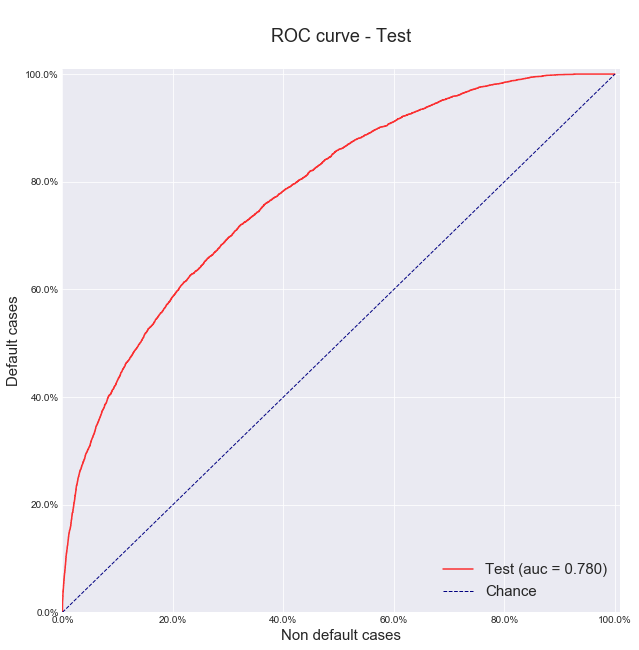

In [21]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)
plot_roc(kernix_check.default, kernix_check.prob, 'Test')

In [25]:
# Feature Importance

#BOOSTER
dtrain_ex=xgb.DMatrix(features.values,
                      label=target.values,
                      feature_names=features.columns)

bst_ex=xgb.train(params,
                 dtrain_ex,
                 num_boost_round=bst.best_iteration
                )
bst_ex.feature_names[:10]

['NoEmp',
 'NewExist',
 'CreateJob',
 'RetainedJob',
 'UrbanRural',
 'Franchise',
 'SBA_ratio',
 'City_INT',
 'State_INT',
 'Zip_INT']

In [26]:
def print_features_importance(bst):
    x = bst.get_fscore()
    sorted_x = sorted(x.items(), key=lambda x: x[1], reverse=True)
    keys_max = [item[0] for item in sorted_x[:30]]
    feat_max = {key: x[key] for key in keys_max}
    features_importance = pd.DataFrame([feat_max]).T
    features_importance = features_importance.rename(columns = {0: 'Score'})
    features_importance = features_importance.sort_values('Score', ascending=False)
    return features_importance

In [27]:
feat_max = print_features_importance(bst_ex)
feat_max.rename(columns = {'Score': 'Accumlated score'}).head(15)

,Accumlated score
Zip_INT,38188
NAICS_INT,34232
City_INT,32242
Bank_INT,19455
NoEmp,16647
State_INT,13131
RetainedJob,13061
BankState_INT,11154
CreateJob,9946
SBA_ratio,4999


In [144]:
# train.groupby(['Zip', 'default']).count().max(1)
# train[train.default == 1].Zip.astype(str).str[:2].value_counts()
# train[train.default == 1].Zip.value_counts()
# train[train.default == 1].City.value_counts()

LOS ANGELES                     514
MIAMI                           285
HOUSTON                         285
NEW YORK                        199
DALLAS                          144
LAS VEGAS                       115
WASHINGTON                       97
SAN DIEGO                        94
PHILADELPHIA                     93
BALTIMORE HIGHLANDS              90
ATLANTA                          89
CHICAGO                          85
SAN FRANCISCO                    74
PITTSBURGH                       72
GLENDALE                         67
SPRINGFIELD                      67
PHOENIX                          66
ORLANDO                          63
EL PASO                          59
LOUISVILLE                       58
DENVER                           57
ARLINGTON                        54
OMAHA                            53
HIALEAH                          53
SAN ANTONIO                      52
AUSTIN                           50
INDIANAPOLIS                     50
SAN JOSE                    

In [108]:
train[train.default == 1].Term.iplot(kind = 'hist')

In [109]:
train[train.default == 0].Term.iplot(kind = 'hist')